In [14]:
import glob
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
from scipy.optimize import minimize

from openfermion.config import *
from openfermionprojectq import *

from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.ops import FermionOperator

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer, Simulator
from projectq.ops import (BasicGate, QubitOperator, X, CNOT, Measure, All, Ry, Swap)

from projectq import MainEngine
from projectq.meta import Control

from itertools import product
from math import sqrt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
# Hamiltonian is a single nuclear boson in multiple orbitals 3^S state
# Basis states is orbital occupied or not, with only one occupied

def KD(a,b):
    # KroneckerDelta
    return(1.0 if a==b else 0.0)

def NuclearMatrixElement(n,np):
    # T = hw/2*((2n+3/2)*KroneckerDelta(n,np) 
    #           +Sqrt(n*(n+1/2)*KroneckerDelta(n,np+1))
    #           +Sqrt((n+1)*(n+3/2)*KroneckerDelta(n,np-1))
    # V = V0*KroneckerDelta(n,0)*KroneckerDelta(n,np)
    V0 = -5.6865811
    hw = 7.0
    return(V0*KD(0,n)*KD(n,np) 
           + hw/2.0*((2.0*float(n)+1.5)*KD(n,np)
           -sqrt(float(n)*(float(n)+0.5))*KD(n,np+1)
           -sqrt(float(n+1)*(float(n)+1.5))*KD(n,np-1)))
    
def NuclearHamiltonian(BasisDimension): 
    # Sum(n,np from 0,BasisDimension-1) <np|T+V|n>a^_n a_np
    return(sum([FermionOperator(str(n)+'^ '+str(np),NuclearMatrixElement(n,np))
                for n,np in product(range(BasisDimension),range(BasisDimension))],
                FermionOperator()))

def NuclearHamiltonianOrder(QubitPosition):
    # Sum(n,np from 0,BasisDimension-1) <np|T+V|n>a^_n a_np
    return(sum([FermionOperator(str(QubitPosition[n])+'^ '+str(QubitPosition[np]),NuclearMatrixElement(n,np))
                for n,np in product(range(len(QubitPosition)),range(len(QubitPosition)))],
                FermionOperator()))

def SingleExcitations(Amplitudes):
    Dimension = len(Amplitudes)
    SingleExcitedArray = []
    for Element in range(Dimension):
        SingleExcitedArray.append([[0,Element+1],Amplitudes[Element]])
    return(SingleExcitedArray)

def energy_objective_exact(packed_amplitudes):
    wavefunction = CompileEngine.allocate_qureg(len(packed_amplitudes)+1)
    X | wavefunction[0]
    evolution_operator = uccsd_evolution(uccsd_operator(SingleExcitations(packed_amplitudes),[]))
    evolution_operator | wavefunction
    CompileEngine.flush()
    energy = CompileEngine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    CompileEngine.flush(deallocate_qubits = True)
    return energy 

In [3]:
# Deuteron Hamiltonian 
MaximumDimension = 4
for BasisDimension in range(1,MaximumDimension+1):
    print('Basis Dimension: ',BasisDimension)
    print()
    FermionHamiltonian = NuclearHamiltonian(BasisDimension)
    print('Fermion Hamiltonian')
    print(FermionHamiltonian)
    QubitHamiltonian = jordan_wigner(FermionHamiltonian)
    QubitHamiltonian.compress()
    print()
    print('Qubit Hamiltonian')
    print(QubitHamiltonian)
    print()
    print()

Basis Dimension:  1

Fermion Hamiltonian
-0.4365810999999997 [0^ 0]

Qubit Hamiltonian
-0.21829054999999986 I +
0.21829054999999986 Z0


Basis Dimension:  2

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1]

Qubit Hamiltonian
5.90670945 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1


Basis Dimension:  3

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1] +
-7.826237921249264 [1^ 2] +
0.0 [2^ 0] +
-7.826237921249264 [2^ 1] +
19.25 [2^ 2]

Qubit Hamiltonian
15.531709450000001 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1 +
-3.913118960624632 Y1 Y2 +
-3.913118960624632 X1 X2 +
-9.625 Z2


Basis Dimension:  4

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
0.0 [0^ 3] +
-4.286607049870561 [1^ 0] +
12.25 [1

In [4]:
# UCC Ansatz for 2 to 4 orbitals

# Two orbitals
single_amplitudes = [[[0, 1], 1.0]]
double_amplitudes = []
generator = uccsd_operator(single_amplitudes,double_amplitudes)
print('Two orbitals')
print()
print('Fermion Generator')
print(generator)
generator_jw = jordan_wigner(generator)
print()
print('Jordan-Wigner Transformed')
print(generator_jw)
print()
evolution_operator = uccsd_evolution(generator)
print('Evolution operator')
print(evolution_operator)
print()
#print('Circuit')
#cmd_printer = _printer.CommandPrinter()
#compiler_engine = uccsd_trotter_engine(cmd_printer)
#wavefunction = []
#wavefunction = compiler_engine.allocate_qureg(2)
#evolution_operator = uccsd_evolution(generator)
#evolution_operator | wavefunction
#compiler_engine.flush()
#print()
print()
# Three orbitals
single_amplitudes = [[[0, 1], 1.0],[[0, 2], 2.0]]
double_amplitudes = []
generator = uccsd_operator(single_amplitudes,double_amplitudes)
print('Three orbitals')
print()
print('Fermion Generator')
print(generator)
generator_jw = jordan_wigner(generator)
print()
print('Jordan-Wigner Transformed')
print(generator_jw)
print()
evolution_operator = uccsd_evolution(generator)
print('Evolution operator')
print(evolution_operator)
print()
print()
# Four orbitals
single_amplitudes = [[[0, 1], 1.0],[[0, 2], 2.0],[[0, 3], 3.0]]
double_amplitudes = []
generator = uccsd_operator(single_amplitudes,double_amplitudes)
print('Four orbitals')
print()
print('Fermion Generator')
print(generator)
generator_jw = jordan_wigner(generator)
print()
print('Jordan-Wigner Transformed')
print(generator_jw)
print()
evolution_operator = uccsd_evolution(generator)
print('Evolution operator')
print(evolution_operator)


Two orbitals

Fermion Generator
1.0 [0^ 1] +
-1.0 [1^ 0]

Jordan-Wigner Transformed
-0.5j Y0 X1 +
0.5j X0 Y1

Evolution operator
exp(-1j * (-0.5 Y0 X1 +
0.5 X0 Y1))


Three orbitals

Fermion Generator
1.0 [0^ 1] +
-1.0 [1^ 0] +
2.0 [0^ 2] +
-2.0 [2^ 0]

Jordan-Wigner Transformed
-0.5j Y0 X1 +
0.5j X0 Y1 +
-1j Y0 Z1 X2 +
1j X0 Z1 Y2

Evolution operator
exp(-1j * (-0.5 Y0 X1 +
0.5 X0 Y1 +
-1.0 Y0 Z1 X2 +
1.0 X0 Z1 Y2))


Four orbitals

Fermion Generator
1.0 [0^ 1] +
-1.0 [1^ 0] +
2.0 [0^ 2] +
-2.0 [2^ 0] +
3.0 [0^ 3] +
-3.0 [3^ 0]

Jordan-Wigner Transformed
-0.5j Y0 X1 +
0.5j X0 Y1 +
-1j Y0 Z1 X2 +
1j X0 Z1 Y2 +
-1.5j Y0 Z1 Z2 X3 +
1.5j X0 Z1 Z2 Y3

Evolution operator
exp(-1j * (-0.5 Y0 X1 +
0.5 X0 Y1 +
-1.0 Y0 Z1 X2 +
1.0 X0 Z1 Y2 +
-1.5 Y0 Z1 Z2 X3 +
1.5 X0 Z1 Z2 Y3))


In [5]:
# Two orbitals using circuit 

FermionHamiltonian = NuclearHamiltonian(2)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

# Loop over angle theta
ThetaParameters = np.linspace(-np.pi,np.pi,101)

MeasureLabels = ['Z0', 'Z1', 'X0 X1', 'Y0 Y1']
ExpectationValues = {}
for Label in MeasureLabels:
    ExpectationValues[Label] = []
Energies = []

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1]

Qubit Hamiltonian
5.90670945 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1



In [6]:
compiler_engine = MainEngine()
for ThetaVal in ThetaParameters:
    wavefunction = compiler_engine.allocate_qureg(2)
    X | wavefunction[0]
    Ry(ThetaVal) | wavefunction[1]
    CNOT | (wavefunction[1],wavefunction[0])
    compiler_engine.flush()
    for Label in MeasureLabels:
        ExpectationValues[Label].append(compiler_engine.backend.get_expectation_value(QubitOperator(Label), wavefunction))
    Energies.append(compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction))
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits=True)

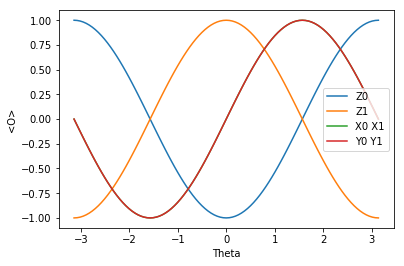

In [7]:
pylab.xlabel("Theta")
pylab.ylabel("<O>")
for Label in MeasureLabels:
    pylab.plot(ThetaParameters, ExpectationValues[Label], label=Label)
pylab.legend()

Minimum Energy =  -1.7459868178


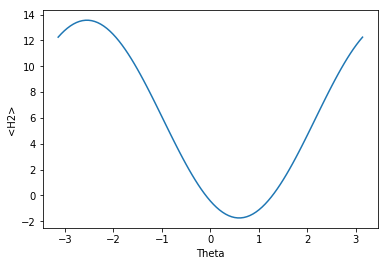

In [8]:
pylab.xlabel("Theta")
pylab.ylabel("<H2>")
pylab.plot(ThetaParameters, Energies)

print('Minimum Energy = ', np.array(Energies).min())

In [9]:
# Two orbitals, using approximation and circuit outlined in ORNL paper
# Doing an L-BFGS-B minization

def energy_objective_two_approximate(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(2)
    X | wavefunction[0]
    Ry(packed_amplitudes) | wavefunction[1]
    CNOT | (wavefunction[1],wavefunction[0])
    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes = 0.3
initial_energy = energy_objective_two_approximate(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_two_approximate, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Energy =  -1.7491598671787676  Amplitudes =  [ 0.59427861]


In [10]:
# Three orbitals, using approximation and circuit outlined in ORNL paper
# Doing a grid of the two parameters

FermionHamiltonian = NuclearHamiltonian(3)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

# Loop over angle theta
ThetaParameters = np.linspace(-np.pi,np.pi,21)
EtaParameters = np.linspace(-np.pi,np.pi,21)

MeasureLabels = ['Z0', 'Z1', 'Z2', 'X0 X1', 'Y0 Y1', 'X1 X2', 'Y1 Y2']
ExpectationValues = {}
for Label in MeasureLabels:
    ExpectationValues[Label] = []
Energies = []

Energies2Parameters = []
compiler_engine = MainEngine()

for ThetaVal in ThetaParameters:
    EnergyList = []
    for EtaVal in EtaParameters:
        wavefunction = compiler_engine.allocate_qureg(3)
        X | wavefunction[0]
        Ry(EtaVal) | wavefunction[1]
        Ry(ThetaVal) | wavefunction[2]
        CNOT | (wavefunction[2],wavefunction[0])
        CNOT | (wavefunction[0],wavefunction[1])
        Ry(-EtaVal) | wavefunction[1]
        CNOT | (wavefunction[0],wavefunction[1])
        CNOT | (wavefunction[1],wavefunction[0])
        compiler_engine.flush()
        for Label in MeasureLabels:
            ExpectationValues[Label].append(compiler_engine.backend.get_expectation_value(QubitOperator(Label), wavefunction))
        EnergyList.append(compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction))
        All(Measure) | wavefunction
        compiler_engine.flush(deallocate_qubits=True)
    Energies2Parameters.append(EnergyList)

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1] +
-7.826237921249264 [1^ 2] +
0.0 [2^ 0] +
-7.826237921249264 [2^ 1] +
19.25 [2^ 2]

Qubit Hamiltonian
15.531709450000001 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1 +
-3.913118960624632 Y1 Y2 +
-3.913118960624632 X1 X2 +
-9.625 Z2



Minimum Energy =  -1.97828654611


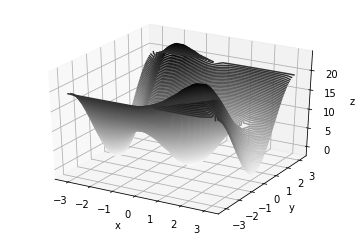

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(ThetaParameters, EtaParameters, Energies2Parameters, 101, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

print('Minimum Energy = ', np.array(Energies2Parameters).min())

In [12]:
# Three orbitals, using approximation and circuit outlined in ORNL paper
# Doing an L-BFGS-B minization

def energy_objective_three_approximate(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(3)
    X | wavefunction[0]
    Ry(packed_amplitudes[0]) | wavefunction[1]
    Ry(packed_amplitudes[1]) | wavefunction[2]
    CNOT | (wavefunction[2],wavefunction[0])
    CNOT | (wavefunction[0],wavefunction[1])
    Ry(-packed_amplitudes[0]) | wavefunction[1]
    CNOT | (wavefunction[0],wavefunction[1])
    CNOT | (wavefunction[1],wavefunction[0])
    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes =[0.3, 0.3]
initial_energy = energy_objective_three_approximate(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_three_approximate, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Energy =  -2.045670889784903  Amplitudes =  [ 0.35910032  0.25688292]


In [13]:
# Three orbitals, using exact unitary shown in ORNL paper
# Doing an L-BFGS-B minization

CompileEngine = uccsd_trotter_engine()

current_amplitudes = [0.3] * 2
initial_energy = energy_objective_exact(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_exact, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Energy =  -2.045670889784553  Amplitudes =  [ 0.35600987  0.13708666]


In [21]:
# Three orbitals, using approximation and circuit outlined in ORNL paper
# Doing an L-BFGS-B minization
# Now assuming the three qubits are in a chain 

QubitPosition = [1,2,0] # To avoid any swaps

FermionHamiltonian = NuclearHamiltonianOrder(QubitPosition)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

def energy_objective_three_approximate(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(3)
    Ry(packed_amplitudes[1]) | wavefunction[0]
    X | wavefunction[1]
    Ry(packed_amplitudes[0]) | wavefunction[2]
    CNOT | (wavefunction[0],wavefunction[1])
    CNOT | (wavefunction[1],wavefunction[2])
    Ry(-packed_amplitudes[0]) | wavefunction[2]
    CNOT | (wavefunction[1],wavefunction[2])
    CNOT | (wavefunction[2],wavefunction[1])
    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes =[0.3, 0.3]
initial_energy = energy_objective_three_approximate(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_three_approximate, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Fermion Hamiltonian
-0.4365810999999997 [1^ 1] +
-4.286607049870561 [1^ 2] +
0.0 [1^ 0] +
-4.286607049870561 [2^ 1] +
12.25 [2^ 2] +
-7.826237921249264 [2^ 0] +
0.0 [0^ 1] +
-7.826237921249264 [0^ 2] +
19.25 [0^ 0]

Qubit Hamiltonian
15.531709450000001 I +
0.21829054999999986 Z1 +
-2.1433035249352805 Y1 Y2 +
-2.1433035249352805 X1 X2 +
-6.125 Z2 +
-3.913118960624632 X0 Z1 X2 +
-3.913118960624632 Y0 Z1 Y2 +
-9.625 Z0

Energy =  -2.045670889784903  Amplitudes =  [ 0.35910032  0.25688292]


In [14]:
# Four orbitals, using exact unitary
# Doing an L-BFGS-B minization

FermionHamiltonian = NuclearHamiltonian(4)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

CompileEngine = uccsd_trotter_engine()

current_amplitudes = [0.3] * 3
initial_energy = energy_objective_exact(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_exact, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
0.0 [0^ 3] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1] +
-7.826237921249264 [1^ 2] +
0.0 [1^ 3] +
0.0 [2^ 0] +
-7.826237921249264 [2^ 1] +
19.25 [2^ 2] +
-11.341296222213757 [2^ 3] +
0.0 [3^ 0] +
0.0 [3^ 1] +
-11.341296222213757 [3^ 2] +
26.25 [3^ 3]

Qubit Hamiltonian
28.65670945 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1 +
-3.913118960624632 Y1 Y2 +
-3.913118960624632 X1 X2 +
-9.625 Z2 +
-5.670648111106878 Y2 Y3 +
-5.670648111106878 X2 X3 +
-13.125 Z3

Energy =  -2.1439810224544757  Amplitudes =  [ 0.37241736  0.18229959  0.07369941]


In [15]:
# Four orbitals, using approximation and associated circuit
# Doing an L-BFGS-B minization

def energy_objective_four_approx(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(4)
    X | wavefunction[0]
    Ry(packed_amplitudes[0]) | wavefunction[1]
    Ry(packed_amplitudes[1]) | wavefunction[2]
    Ry(packed_amplitudes[2]) | wavefunction[3]
    CNOT | (wavefunction[3],wavefunction[0])
    CNOT | (wavefunction[0],wavefunction[2])
    Ry(-packed_amplitudes[1]) | wavefunction[2]
    CNOT | (wavefunction[0],wavefunction[2])
    CNOT | (wavefunction[2],wavefunction[0])
    CNOT | (wavefunction[0],wavefunction[1])
    Ry(-packed_amplitudes[0]) | wavefunction[1]
    CNOT | (wavefunction[0],wavefunction[1])
    CNOT | (wavefunction[1],wavefunction[0])
    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes =[0.3] * 3
initial_energy = energy_objective_four_approx(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_four_approx, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Energy =  -2.1439810224544473  Amplitudes =  [ 0.37904887  0.17006805  0.13499989]


In [28]:
# Four orbitals, using approximation and associated circuit
# Doing an L-BFGS-B minization
# Qubit placement in chain to minimize swaps

# Placement to do circuit with only one swap of qubits 2 and 3, 
# where we initialize (on left) as 3 and 2 and end as 2 and 3 (on right of graph)
QubitPosition = [1,0,2,3] 

FermionHamiltonian = NuclearHamiltonianOrder(QubitPosition)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print() 

def energy_objective_four_approx(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(4)
    Ry(packed_amplitudes[0]) | wavefunction[0]
    X | wavefunction[1]
    Ry(packed_amplitudes[2]) | wavefunction[2]
    Ry(packed_amplitudes[1]) | wavefunction[3]
    CNOT | (wavefunction[2],wavefunction[1])
    # Do a swap as three CNOTs
    CNOT | (wavefunction[2],wavefunction[3])
    CNOT | (wavefunction[3],wavefunction[2])
    CNOT | (wavefunction[2],wavefunction[3])
    # Done with swap
    CNOT | (wavefunction[1],wavefunction[2])
    Ry(-packed_amplitudes[1]) | wavefunction[2]
    CNOT | (wavefunction[1],wavefunction[2])
    CNOT | (wavefunction[2],wavefunction[1])
    CNOT | (wavefunction[1],wavefunction[0])
    Ry(-packed_amplitudes[0]) | wavefunction[0]
    CNOT | (wavefunction[1],wavefunction[0])
    CNOT | (wavefunction[0],wavefunction[1])
    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes =[0.3] * 3
initial_energy = energy_objective_four_approx(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_four_approx, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Fermion Hamiltonian
-0.4365810999999997 [1^ 1] +
-4.286607049870561 [1^ 0] +
0.0 [1^ 2] +
0.0 [1^ 3] +
-4.286607049870561 [0^ 1] +
12.25 [0^ 0] +
-7.826237921249264 [0^ 2] +
0.0 [0^ 3] +
0.0 [2^ 1] +
-7.826237921249264 [2^ 0] +
19.25 [2^ 2] +
-11.341296222213757 [2^ 3] +
0.0 [3^ 1] +
0.0 [3^ 0] +
-11.341296222213757 [3^ 2] +
26.25 [3^ 3]

Qubit Hamiltonian
28.65670945 I +
0.21829054999999986 Z1 +
-2.1433035249352805 X0 X1 +
-2.1433035249352805 Y0 Y1 +
-6.125 Z0 +
-3.913118960624632 Y0 Z1 Y2 +
-3.913118960624632 X0 Z1 X2 +
-9.625 Z2 +
-5.670648111106878 Y2 Y3 +
-5.670648111106878 X2 X3 +
-13.125 Z3

Energy =  -2.1439810224544438  Amplitudes =  [ 0.37904887  0.17006805  0.13499984]


In [16]:
# Five orbitals, using exact unitary
# Doing an L-BFGS-B minization

FermionHamiltonian = NuclearHamiltonian(5)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

CompileEngine = uccsd_trotter_engine()

current_amplitudes = [0.3] * 4
initial_energy = energy_objective_exact(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_exact, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
0.0 [0^ 3] +
0.0 [0^ 4] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1] +
-7.826237921249264 [1^ 2] +
0.0 [1^ 3] +
0.0 [1^ 4] +
0.0 [2^ 0] +
-7.826237921249264 [2^ 1] +
19.25 [2^ 2] +
-11.341296222213757 [2^ 3] +
0.0 [2^ 4] +
0.0 [3^ 0] +
0.0 [3^ 1] +
-11.341296222213757 [3^ 2] +
26.25 [3^ 3] +
-14.849242404917497 [3^ 4] +
0.0 [4^ 0] +
0.0 [4^ 1] +
0.0 [4^ 2] +
-14.849242404917497 [4^ 3] +
33.25 [4^ 4]

Qubit Hamiltonian
45.28170945 I +
0.21829054999999986 Z0 +
-2.1433035249352805 Y0 Y1 +
-2.1433035249352805 X0 X1 +
-6.125 Z1 +
-3.913118960624632 Y1 Y2 +
-3.913118960624632 X1 X2 +
-9.625 Z2 +
-5.670648111106878 Y2 Y3 +
-5.670648111106878 X2 X3 +
-13.125 Z3 +
-7.424621202458749 Y3 Y4 +
-7.424621202458749 X3 X4 +
-16.625 Z4

Energy =  -2.183591701827531  Amplitudes =  [ 0.37784224  0.19991221  0.10364752  0.04360554]


In [17]:
# Eight orbitals, using exact unitary
# Doing an L-BFGS-B minization

FermionHamiltonian = NuclearHamiltonian(8)
print('Fermion Hamiltonian')
print(FermionHamiltonian)
QubitHamiltonian = jordan_wigner(FermionHamiltonian)
QubitHamiltonian.compress()
print()
print('Qubit Hamiltonian')
print(QubitHamiltonian)
print()

CompileEngine = uccsd_trotter_engine()

current_amplitudes = [0.3] * 7
initial_energy = energy_objective_exact(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_exact, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Fermion Hamiltonian
-0.4365810999999997 [0^ 0] +
-4.286607049870561 [0^ 1] +
0.0 [0^ 2] +
0.0 [0^ 3] +
0.0 [0^ 4] +
0.0 [0^ 5] +
0.0 [0^ 6] +
0.0 [0^ 7] +
-4.286607049870561 [1^ 0] +
12.25 [1^ 1] +
-7.826237921249264 [1^ 2] +
0.0 [1^ 3] +
0.0 [1^ 4] +
0.0 [1^ 5] +
0.0 [1^ 6] +
0.0 [1^ 7] +
0.0 [2^ 0] +
-7.826237921249264 [2^ 1] +
19.25 [2^ 2] +
-11.341296222213757 [2^ 3] +
0.0 [2^ 4] +
0.0 [2^ 5] +
0.0 [2^ 6] +
0.0 [2^ 7] +
0.0 [3^ 0] +
0.0 [3^ 1] +
-11.341296222213757 [3^ 2] +
26.25 [3^ 3] +
-14.849242404917497 [3^ 4] +
0.0 [3^ 5] +
0.0 [3^ 6] +
0.0 [3^ 7] +
0.0 [4^ 0] +
0.0 [4^ 1] +
0.0 [4^ 2] +
-14.849242404917497 [4^ 3] +
33.25 [4^ 4] +
-18.354154842977653 [4^ 5] +
0.0 [4^ 6] +
0.0 [4^ 7] +
0.0 [5^ 0] +
0.0 [5^ 1] +
0.0 [5^ 2] +
0.0 [5^ 3] +
-18.354154842977653 [5^ 4] +
40.25 [5^ 5] +
-21.857492994394395 [5^ 6] +
0.0 [5^ 7] +
0.0 [6^ 0] +
0.0 [6^ 1] +
0.0 [6^ 2] +
0.0 [6^ 3] +
0.0 [6^ 4] +
-21.857492994394395 [6^ 5] +
47.25 [6^ 6] +
-25.359909305831515 [6^ 7] +
0.0 [7^ 0] +
0.0 [7^

In [19]:
# Four orbitals, using approximation and associated circuit
# Doing an L-BFGS-B minization

def energy_objective_eight_approx(packed_amplitudes):
    wavefunction = compiler_engine.allocate_qureg(8)
    X | wavefunction[0]
    Ry(packed_amplitudes[0]) | wavefunction[1]
    Ry(packed_amplitudes[1]) | wavefunction[2]
    Ry(packed_amplitudes[2]) | wavefunction[3]
    Ry(packed_amplitudes[3]) | wavefunction[4]
    Ry(packed_amplitudes[4]) | wavefunction[5]
    Ry(packed_amplitudes[5]) | wavefunction[6]
    Ry(packed_amplitudes[6]) | wavefunction[7]
    
    CNOT | (wavefunction[7],wavefunction[0])

    # Entange one at a time, simialr to ORNL paper
    
    for Qubit in range(6,0,-1):
        CNOT | (wavefunction[0],wavefunction[Qubit])
        Ry(-packed_amplitudes[Qubit-1]) | wavefunction[Qubit]
        CNOT | (wavefunction[0],wavefunction[Qubit])
        CNOT | (wavefunction[Qubit],wavefunction[0])

    compiler_engine.flush()
    energy = compiler_engine.backend.get_expectation_value(QubitHamiltonian, wavefunction)
    All(Measure) | wavefunction
    compiler_engine.flush(deallocate_qubits = True)
    return energy 

current_amplitudes =[0.3] * 7
initial_energy = energy_objective_eight_approx(current_amplitudes)

# Run VQE Optimization to find new CCSD parameters
opt_result = minimize(energy_objective_eight_approx, current_amplitudes, method="l-bfgs-b", options={'disp':True})

print('Energy = ', opt_result.fun, ' Amplitudes = ', opt_result.x)

Energy =  -2.2150378642283677  Amplitudes =  [ 0.39327337  0.19967876  0.11570712  0.07070754  0.04331481  0.02485208
  0.02232059]
